In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp
import source.modelling_classification as modl

In [2]:
data = dp.prepare_data()
data['equity_premium_c'] = ((data['equity_premium'] > 0) ).astype(int)

/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
import matplotlib.pyplot as plt



plt.hist(data['equity_premium'], bins=50)
plt.title('Distribution of Equity Premium')
plt.xlabel('Equity Premium')
plt.ylabel('Frequency')
plt.show()




In [ ]:

plt.hist(data['equity_premium_c'], bins=50)
plt.title('Distribution of Equity Premium')
plt.xlabel('Equity Premium')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# try to use the models to predict the equity premium classification 

# start with simple logistic regression model

# go on in the same iterative manner as for regression models



monthly_vars = [
    "vp","impvar","vrp","lzrt","ogap","wtexas","sntm","ndrbL","skvw","tail",
    "fbm","dtoy","dtoat","ygap","rdsp","rsvix","tchi","avgcor","shtint",
    "disag","ntis","tby","lty","ltr","tms","dfy","dfr","infl"
]
monthly_vars = [v for v in monthly_vars if v in data.columns]

ranking = modl.rank_monthly_predictors_cls(
    data,
    monthly_vars=monthly_vars,
    target_col="equity_premium_c",
    start_oos="1965-01-01",
    lag=1,
    threshold=0.5,
    rank_by="acc",   # or "skill"
    C=1.0, penalty="l2", solver="lbfgs", max_iter=1000
)

In [ ]:
# --- Chronos v2 classification on a binary series (plain code, no functions) ---
# Target/Context: equity_premium_c (0/1)
# Probability estimate: π ≈ mean of returned quantiles (levels 0.1..0.9)

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# -------------------- config --------------------
start_oos   = "1965-01-01"
model_id    = "amazon/chronos-bolt-large"
min_history = 24
threshold   = 0.5
q_levels    = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Bolt-supported quantiles

# -------------------- data prep --------------------
# Expect `data` with monthly 'equity_premium_c' (0/1) index
df = data.sort_index()[["equity_premium_c"]].dropna().asfreq("MS")
y = df["equity_premium_c"].astype("float32")
test_idx = y.index[y.index >= pd.Timestamp(start_oos)]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[Chronos-CLS] {df.index[0].date()}→{df.index[-1].date()}  n={len(df)}  device={device}")

# -------------------- model --------------------
pipe = BaseChronosPipeline.from_pretrained(
    model_id,
    device_map=device,
    torch_dtype=(torch.bfloat16 if torch.cuda.is_available() else torch.float32),
)

# -------------------- expanding OOS --------------------
probs, trues, dates = [], [], []

for date_t in test_idx:
    pos = y.index.get_loc(date_t)
    if pos < min_history:
        continue

    # history (strictly before current date)
    ctx = y.iloc[:pos].to_numpy(dtype="float32")
    if ctx.size == 0 or np.isnan(ctx).any():
        continue

    with torch.inference_mode():
        # Returns (quantiles, mean). We'll use quantiles only.
        q_pred, _ = pipe.predict_quantiles(
            context=[torch.tensor(ctx)],
            prediction_length=1,
            quantile_levels=q_levels,
        )

    # -------- normalize q_pred to 1-D (len = len(q_levels)) --------
    q = q_pred
    if hasattr(q, "detach"):
        q = q.detach().cpu().numpy()
    q = np.asarray(q)

    nq = len(q_levels)
    if q.ndim == 1 and q.shape[0] == nq:
        q_vals = q
    elif q.ndim == 2:
        if q.shape[0] == nq:        # (nq, pred_len)
            q_vals = q[:, 0]
        elif q.shape[1] == nq:      # (pred_len, nq)
            q_vals = q[0, :]
        else:
            raise ValueError(f"Unexpected 2D quantile shape: {q.shape}")
    elif q.ndim == 3:
        if q.shape[-1] == nq:       # (batch, pred_len, nq)
            q_vals = q[0, 0, :]
        elif q.shape[0] == nq:      # (nq, batch, pred_len)
            q_vals = q[:, 0, 0]
        elif q.shape[1] == nq:      # (batch, nq, pred_len)
            q_vals = q[0, :, 0]
        else:
            raise ValueError(f"Unexpected 3D quantile shape: {q.shape}")
    else:
        raise ValueError(f"Unexpected quantile ndim: {q.ndim}, shape={q.shape}")

    q_vals = np.asarray(q_vals, dtype=float).reshape(-1)

    # Sort by quantile level (safety)
    q_levels_sorted = np.asarray(q_levels, dtype=float)
    order = np.argsort(q_levels_sorted)
    q_vals_sorted   = q_vals[order]

    # -------------------- Bernoulli-friendly probability --------------------
    # For binary targets, the expected value E[Y] equals P(Y=1).
    # With quantiles at equally spaced levels, approximate E[Y] by the mean of Q(p).
    p_pos = float(np.mean(q_vals_sorted))  # ∈ [0,1]

    probs.append(p_pos)
    trues.append(int(y.iloc[pos]))   # true 0/1 at current time
    dates.append(date_t)

# -------------------- evaluate --------------------
if not probs:
    raise RuntimeError("No valid Chronos predictions. Ensure enough history before start_oos.")

y_prob = np.asarray(probs, float)
y_true = np.asarray(trues, int)
dates  = pd.DatetimeIndex(dates)

y_hat = (y_prob >= float(threshold)).astype(int)
acc   = (y_hat == y_true).mean()
brier = np.mean((y_prob - y_true) ** 2)
print(f"[Chronos-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}")

# -------------------- plot --------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, y_prob, label="Predicted P(y=1)", linewidth=1.8)
ax.axhline(float(threshold), linestyle="--", linewidth=1, label=f"Threshold = {threshold}")

mask_pred1 = y_hat == 1
if mask_pred1.any():
    ax.fill_between(dates, 0, 1, where=mask_pred1, transform=ax.get_xaxis_transform(),
                    alpha=0.08, label="Predicted class = 1")

err = (y_hat != y_true)
if err.any():
    ax.scatter(dates[err], y_prob[err], marker="x", s=30, label="Errors")

ax.set_ylim(-0.02, 1.02)
ax.set_ylabel("Predicted probability P(y=1)")
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.step(dates, y_true, where="post", linewidth=1.4, alpha=0.35, label="True class (0/1)")
ax2.set_ylim(-0.2, 1.2)
ax2.set_yticks([0, 1])
ax2.set_ylabel("True class")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left", ncol=2)

ax.set_title("Chronos-Bolt: OOS classification over time (binary series)")
ax.set_xlabel("Date")
fig.tight_layout()
plt.show()



In [ ]:
import torch
from momentfm import MOMENTPipeline

device = "mps" if torch.backends.mps.is_available() else "cpu"

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        "task_name": "classification",
        "n_channels": 1,
        "num_class": 5
    },
)
model.init()
model.to(device)

# Example input
x = torch.randn(4, 1, 512).to(device)
output = model(x_enc=x)

print("Logits:", output.logits)
print("Predicted labels:", output.logits.argmax(dim=1))


[MOMENT-CLS] device=mps


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


1965-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1965-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1966-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1967-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1968-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1969-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1970-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1971-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-05-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-06-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-07-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-08-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-09-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-10-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-11-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1972-12-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1973-01-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1973-02-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1973-03-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


1973-04-01 00:00:00


/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/anaconda3/envs/tsfm/lib/python3.11/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[MOMENT-CLS] steps=100  Acc=0.5400  Brier=0.2574


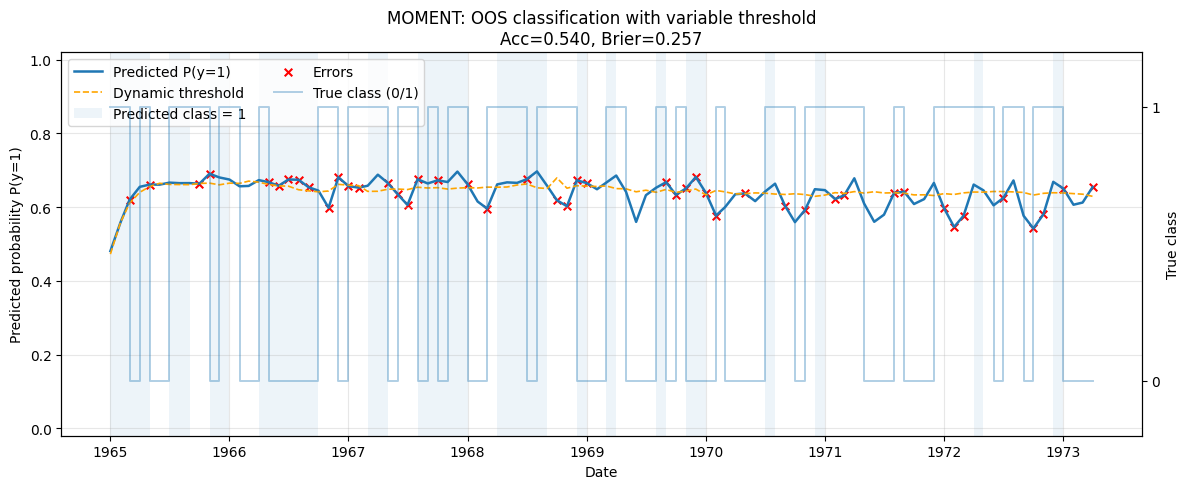

In [27]:
# --- MOMENT OOS classification with dynamic threshold plotting ---
# Input: past continuous equity_premium
# Target: equity_premium_c (0/1) = 1{equity_premium > 0}

from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from momentfm import MOMENTPipeline
import matplotlib.pyplot as plt


def moment_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    batch_size=64,
    epochs_per_step=10,
    lr=1e-4,
    quiet=False,
    model_id="AutonLab/MOMENT-1-small",
    tune_threshold="youden",      # 'youden' | 'majority' | None
    use_class_weight=False,
    train_first_step_only=False,
):
    """Expanding-window one-step-ahead OOS classification with MOMENT,
    returning variable threshold per step and using it in evaluation.
    """

    # ---- device ----
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    if not quiet:
        print(f"[MOMENT-CLS] device={device}")

    # ---- data: continuous + class labels ----
    df = (
        data.sort_index()[["equity_premium", "equity_premium_c"]]
        .dropna()
        .asfreq("MS")
    )
    y_cont = df["equity_premium"].astype("float32")
    y_cls = df["equity_premium_c"].astype("int64")

    start_oos = pd.Timestamp(start_oos)
    test_idx = y_cls.index[y_cls.index >= start_oos]

    # ---- model ----
    model = MOMENTPipeline.from_pretrained(
        model_id,
        model_kwargs={"task_name": "classification", "n_channels": 1, "num_class": 2},
    )
    model.init()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # ---- helpers ----
    def make_windows(series_cont, series_cls, upto_pos):
        x_arr = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        y_arr = series_cls.iloc[:upto_pos].to_numpy(dtype=np.int64)
        Xs, ys = [], []
        for t in range(seq_len, len(x_arr)):
            Xs.append(x_arr[t - seq_len : t])
            ys.append(y_arr[t])
        if not Xs:
            return None, None
        X = torch.from_numpy(np.stack(Xs)).float().unsqueeze(1)
        y = torch.from_numpy(np.asarray(ys, dtype=np.int64))
        return X, y

    def make_ctx(series_cont, upto_pos):
        hist = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        if hist.size < seq_len:
            hist = np.hstack([np.zeros(seq_len - hist.size, np.float32), hist])
        else:
            hist = hist[-seq_len:]
        return torch.from_numpy(hist).view(1, 1, seq_len)

    # ---- expanding OOS ----
    probs, trues, dates, thr_list = [], [], [], []
    has_trained_once = False
    i=0
    for date_t in test_idx:
        i+=1
        if i > 100:
            break
        if not quiet:
            print(date_t)
        pos = y_cls.index.get_loc(date_t)
        if pos < max(min_context, seq_len + 1):
            continue

        X_train, y_train = make_windows(y_cont, y_cls, upto_pos=pos)
        if X_train is None or len(X_train) < 10 or len(torch.unique(y_train)) < 2:
            continue

        # train once or every step
        if (not train_first_step_only) or (train_first_step_only and not has_trained_once):
            if use_class_weight:
                n1 = (y_train == 1).sum().item()
                n0 = (y_train == 0).sum().item()
                w0 = (n1 + n0) / (2.0 * max(1, n0))
                w1 = (n1 + n0) / (2.0 * max(1, n1))
                class_weight = torch.tensor([w0, w1], dtype=torch.float32, device=device)
                criterion = nn.CrossEntropyLoss(weight=class_weight)
            else:
                criterion = nn.CrossEntropyLoss()

            train_loader = DataLoader(
                TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
            )
            model.train()
            for _ in range(epochs_per_step):
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(x_enc=xb)
                    loss = criterion(out.logits, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            has_trained_once = True

        # ---- threshold tuning ----
        thr = 0.5
        if tune_threshold is not None:
            model.eval()
            with torch.inference_mode():
                p_tr = []
                for xb, yb in DataLoader(
                    TensorDataset(X_train, y_train), batch_size=batch_size
                ):
                    pr = torch.softmax(model(x_enc=xb.to(device)).logits, dim=1)[
                        :, 1
                    ].cpu().numpy()
                    p_tr.append(pr)
                p_tr = np.concatenate(p_tr)
                y_tr = y_train.numpy()
            if tune_threshold == "majority":
                thr = float(y_tr.mean())
            elif tune_threshold == "youden":
                fpr, tpr, th = roc_curve(y_tr, p_tr)
                j = tpr - fpr
                thr = float(th[np.argmax(j)]) if len(th) else 0.5

        thr_list.append(thr)

        # ---- predict ----
        model.eval()
        with torch.inference_mode():
            x_ctx = make_ctx(y_cont, upto_pos=pos).to(device)
            p1 = torch.softmax(model(x_enc=x_ctx).logits, dim=1)[0, 1].item()

        probs.append(float(p1))
        trues.append(int(y_cls.iloc[pos]))
        dates.append(date_t)

    if not probs:
        raise RuntimeError("No valid predictions; increase history or lower min_context.")

    y_prob = np.asarray(probs, float)
    y_true = np.asarray(trues, int)
    thr_arr = np.asarray(thr_list, float)
    dates = pd.DatetimeIndex(dates)

    # --- Use variable threshold ---
    y_hat = (y_prob >= thr_arr).astype(int)
    acc = (y_hat == y_true).mean()
    brier = np.mean((y_prob - y_true) ** 2)

    if not quiet:
        print(f"[MOMENT-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}")

    return acc, brier, y_true, y_prob, thr_arr, dates


# ===== run OOS and plot =====
acc, brier, y_t, y_prob, thr_arr, dts = moment_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    quiet=False,
    tune_threshold="youden",     # dynamically tuned threshold
    train_first_step_only=False,  # train only once for speed
)

# --- Plot with variable threshold ---
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dts, y_prob, linewidth=1.8, label="Predicted P(y=1)")
ax.plot(dts, thr_arr, "--", linewidth=1.2, color="orange", label="Dynamic threshold")

mask_pred1 = (y_prob >= thr_arr)
ax.fill_between(dts, 0, 1, where=mask_pred1, transform=ax.get_xaxis_transform(),
                alpha=0.08, label="Predicted class = 1")

err = (mask_pred1.astype(int) != y_t)
ax.scatter(dts[err], y_prob[err], marker="x", s=30, color="red", label="Errors")

ax.set_ylim(-0.02, 1.02)
ax.set_ylabel("Predicted probability P(y=1)")
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.step(dts, y_t, where="post", linewidth=1.4, alpha=0.35, label="True class (0/1)")
ax2.set_ylim(-0.2, 1.2)
ax2.set_yticks([0, 1])
ax2.set_ylabel("True class")

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc="upper left", ncol=2)

ax.set_title(f"MOMENT: OOS classification with variable threshold\nAcc={acc:.3f}, Brier={brier:.3f}")
ax.set_xlabel("Date")
fig.tight_layout()
plt.show()


(array([ 1.,  0.,  1.,  5.,  5., 12.,  9., 19., 37., 11.]),
 array([0.48065272, 0.50225376, 0.52385479, 0.54545583, 0.56705686,
        0.5886579 , 0.61025894, 0.63185997, 0.65346101, 0.67506205,
        0.69666308]),
 <BarContainer object of 10 artists>)

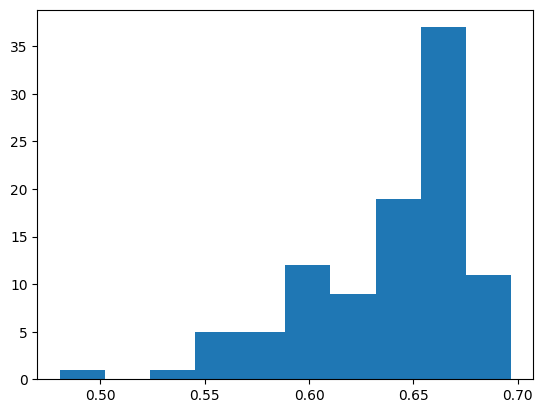

In [28]:
plt.hist(y_prob)

(array([45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 55.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

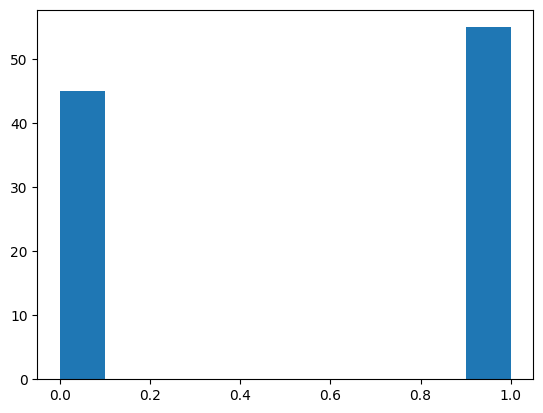

In [29]:
plt.hist(y_t)

[LOGIT-CLS] span 1926-01-01 → 2024-12-01  n=1188
1965-01-01 00:00:00
1965-02-01 00:00:00
1965-03-01 00:00:00
1965-04-01 00:00:00
1965-05-01 00:00:00
1965-06-01 00:00:00
1965-07-01 00:00:00
1965-08-01 00:00:00
1965-09-01 00:00:00
1965-10-01 00:00:00
1965-11-01 00:00:00
1965-12-01 00:00:00
1966-01-01 00:00:00
1966-02-01 00:00:00
1966-03-01 00:00:00
1966-04-01 00:00:00
1966-05-01 00:00:00
1966-06-01 00:00:00
1966-07-01 00:00:00
1966-08-01 00:00:00
1966-09-01 00:00:00
1966-10-01 00:00:00
1966-11-01 00:00:00
1966-12-01 00:00:00
1967-01-01 00:00:00
1967-02-01 00:00:00
1967-03-01 00:00:00
1967-04-01 00:00:00
1967-05-01 00:00:00
1967-06-01 00:00:00
1967-07-01 00:00:00
1967-08-01 00:00:00
1967-09-01 00:00:00
1967-10-01 00:00:00
1967-11-01 00:00:00
1967-12-01 00:00:00
1968-01-01 00:00:00
1968-02-01 00:00:00
1968-03-01 00:00:00
1968-04-01 00:00:00
1968-05-01 00:00:00
1968-06-01 00:00:00
1968-07-01 00:00:00
1968-08-01 00:00:00
1968-09-01 00:00:00
1968-10-01 00:00:00
1968-11-01 00:00:00
1968-12-01 

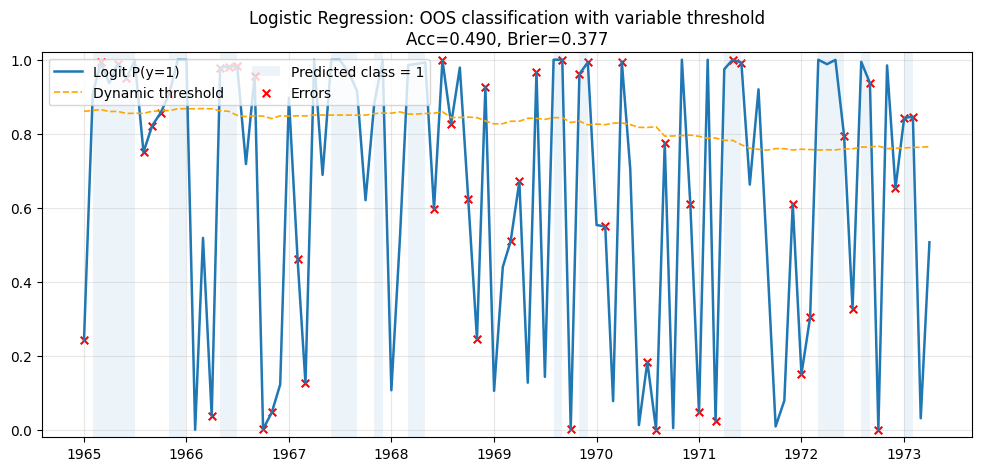

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd


def logit_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    tune_threshold="youden",   # 'youden' | 'majority' | None
    quiet=False,
):
    """
    Expanding-window one-step-ahead OOS classification using logistic regression baseline.
    Mirrors moment_cls_oos() for fair comparison.

    - Inputs X_t: past seq_len values of *continuous* equity_premium.
    - Target y_t: equity_premium_c[t] (0/1) = sign of equity_premium[t].
    """

    # ---- data: continuous + class labels ----
    df = (
        data.sort_index()[["equity_premium", "equity_premium_c"]]
        .dropna()
        .asfreq("MS")
    )
    y_cont = df["equity_premium"].astype("float32")
    y_cls  = df["equity_premium_c"].astype("int64")

    start_oos = pd.Timestamp(start_oos)
    test_idx  = y_cls.index[y_cls.index >= start_oos]

    if not quiet:
        print(f"[LOGIT-CLS] span {y_cls.index[0].date()} → {y_cls.index[-1].date()}  n={len(y_cls)}")

    # ---- helpers ----
    def make_windows(series_cont, series_cls, upto_pos):
        """Build supervised windows up to position."""
        x_arr = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        y_arr = series_cls.iloc[:upto_pos].to_numpy(dtype=np.int64)
        Xs, ys = [], []
        for t in range(seq_len, len(x_arr)):
            Xs.append(x_arr[t-seq_len:t])
            ys.append(y_arr[t])
        if not Xs:
            return None, None
        X = np.stack(Xs)
        y = np.asarray(ys, dtype=np.int64)
        return X, y

    def make_ctx(series_cont, upto_pos):
        hist = series_cont.iloc[:upto_pos].to_numpy(dtype=np.float32)
        if hist.size < seq_len:
            hist = np.hstack([np.zeros(seq_len - hist.size, np.float32), hist])
        else:
            hist = hist[-seq_len:]
        return hist.reshape(1, -1)

    # ---- expanding OOS ----
    probs, trues, dates, thr_list = [], [], [], []
    i = 0
    for date_t in test_idx:
        i+=1
        if i > 100:
            break
        if not quiet:
            print(date_t)

        pos = y_cls.index.get_loc(date_t)
        if pos < max(min_context, seq_len + 1):
            continue

        X_train, y_train = make_windows(y_cont, y_cls, upto_pos=pos)
        if X_train is None or len(X_train) < 10 or len(np.unique(y_train)) < 2:
            continue

        # standardize per step
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)

        # fit logistic regression
        clf = LogisticRegression(
            solver="lbfgs",
            penalty="l2",
            C=1.0,
            max_iter=1000,
        )
        clf.fit(X_train_std, y_train)

        # tune threshold (optional)
        thr = 0.5
        if tune_threshold is not None:
            p_tr = clf.predict_proba(X_train_std)[:, 1]
            if tune_threshold == "majority":
                thr = float(y_train.mean())
            elif tune_threshold == "youden":
                fpr, tpr, th = roc_curve(y_train, p_tr)
                j = tpr - fpr
                thr = float(th[np.argmax(j)]) if len(th) else 0.5
        thr_list.append(thr)

        # predict one step ahead
        X_ctx = make_ctx(y_cont, upto_pos=pos)
        X_ctx_std = scaler.transform(X_ctx)
        p1 = clf.predict_proba(X_ctx_std)[0, 1]

        probs.append(float(p1))
        trues.append(int(y_cls.iloc[pos]))
        dates.append(date_t)

    if not probs:
        raise RuntimeError("No valid predictions; increase history or lower min_context.")

    # ---- results ----
    y_prob = np.asarray(probs, float)
    y_true = np.asarray(trues, int)
    thr_arr = np.asarray(thr_list, float)
    dates  = pd.DatetimeIndex(dates)

    y_hat = (y_prob >= thr_arr).astype(int)
    acc = (y_hat == y_true).mean()
    brier = np.mean((y_prob - y_true)**2)

    if not quiet:
        print(f"[LOGIT-CLS] steps={len(y_true)}  Acc={acc:.4f}  Brier={brier:.4f}")

    return acc, brier, y_true, y_prob, thr_arr, dates
# Logistic regression baseline
acc_logit, brier_logit, y_true_l, y_prob_l, thr_arr_l, dts_l = logit_cls_oos(
    data,
    start_oos="1965-01-01",
    min_context=120,
    seq_len=256,
    quiet=False,
    tune_threshold="youden",
)

# MOMENT model
# acc_moment, brier_moment, y_true_m, y_prob_m, thr_arr_m, dts_m = moment_cls_oos(
#     data,
#     start_oos="1965-01-01",
#     min_context=120,
#     seq_len=256,
#     quiet=False,
#     tune_threshold="youden",
#     train_first_step_only=False,
# )

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dts_l, y_prob_l, linewidth=1.8, label="Logit P(y=1)")
ax.plot(dts_l, thr_arr_l, "--", linewidth=1.2, color="orange", label="Dynamic threshold")
mask_pred1 = (y_prob_l >= thr_arr_l)
ax.fill_between(dts_l, 0, 1, where=mask_pred1, transform=ax.get_xaxis_transform(),
                alpha=0.08, label="Predicted class = 1")
err = (mask_pred1.astype(int) != y_true_l)
ax.scatter(dts_l[err], y_prob_l[err], marker="x", s=30, color="red", label="Errors")

ax.set_ylim(-0.02, 1.02)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", ncol=2)
ax.set_title(f"Logistic Regression: OOS classification with variable threshold\nAcc={acc_logit:.3f}, Brier={brier_logit:.3f}")
plt.show()

